In [12]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio as rio
import geopandas as gpd
import pandas as pd
import os
from shapely import wkt
from shapely.geometry import box
import leafmap.foliumap as leafmap
import folium
import rioxarray as rioxr
import matplotlib.pyplot as plt
import numpy

In [3]:
pd.options.display.max_columns = 50

In [4]:
CRS = 32629

In [5]:
project_path = os.path.expanduser("~/Documents/Projects/building_damage")
out_dir_path = os.path.join(project_path, "Data/processed")
building_root_path = os.path.join(project_path, "Data/raw/building_footprint")
raw_data_path = os.path.join(project_path, "Data/raw")

In [7]:
name = "Adassil"
delta_event = "before"
rs_test_path = os.path.join(out_dir_path, name, delta_event, "1030010083A10700-visual.tif")

### Calibration

In [9]:
rs = rioxr.open_rasterio(rs_test_path)

<Axes: >

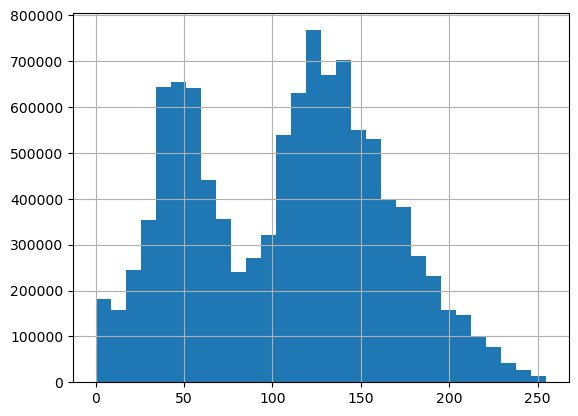

In [21]:
pd.Series(rs.sel(band=1).data.flatten()).hist(bins=30)

OK déjà en reflectance

### Co-registration

https://pygis.io/docs/e_raster_resample.html

In [ ]:
def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
        # open output
        with rasterio.open(outfile, "w", **dst_kwargs) as dst:
            # iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [ ]:
LS = "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
precip = "../data/precipitation_20200601_500m.tif"

reproj_match(infile = LS, 
             match= precip,
             outfile = '../temp/LS_reg_precip.tif')